# Neural networks

Collect a set of photos of your team members. Train the neuron so that she will classify the new photos of the participants well.

## Import libs and load dataset

In [1]:
import numpy as np
np.random.seed(123)

import mtcnn
print(mtcnn.__version__)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.applications import VGG19, imagenet_utils
from keras.preprocessing.image import img_to_array, ImageDataGenerator

Using TensorFlow backend.


0.1.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15580146686756822395
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9447484026893996324
physical_device_desc: "device: XLA_CPU device"
]


## Experimental examples

### Import addition libs

In [3]:
from PIL import Image
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

### Formating image

In [4]:
def extract_face(filename, required_size=(224, 224), resize=False):
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    if resize: image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def print_image(img):
    if isinstance(img, str): img = pyplot.imread(img)
    pyplot.imshow(img)
    pyplot.show()

### Example 1

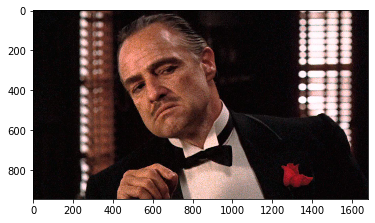

In [5]:
print_image("data/train/don_korleon.jpg")

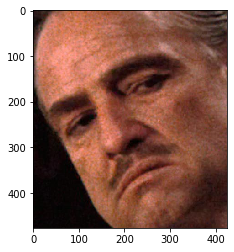

In [6]:
print_image(extract_face("data/train/don_korleon.jpg"))

### Example 2

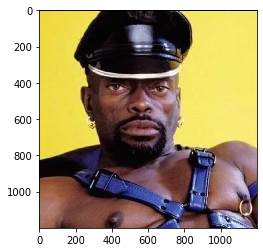

In [7]:
print_image("data/train/dark_lord.jpg")

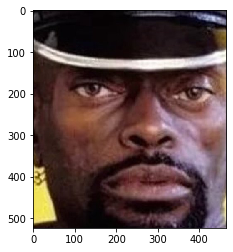

In [8]:
print_image(extract_face("data/train/dark_lord.jpg"))

## Face recognition

### Preparation

In [9]:
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense

In [10]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [11]:
from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

In [12]:
final_layer = Dense(2, activation='softmax')(model.layers[-2].output)
from keras.models import Model
model = Model(model.inputs, final_layer)
for layer in model.layers[:-1]:
    layer.trainable = False

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Learning

In [14]:
import os
dir1 = "data/test/tom/"
dir2 = "data/test/tony/"
files1 = os.listdir(dir1)
files2 = os.listdir(dir2)

In [15]:
images1 = [extract_face(os.path.join(dir1, i), resize=True) for i in files1]
images2 = [extract_face(os.path.join(dir2, i), resize=True) for i in files2]

In [16]:
X_train = images1[:-2] + images2[:-2]
y_train = [[1, 0]] * len(images1[:-2]) + [[0, 1]] * len(images2[:-2])

X_test = images1[-2:]  + images2[-2:]
y_test = [[1, 0], [1, 0], [0, 1], [0, 1]]

In [17]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow(np.asarray(X_train), np.asarray(y_train))

In [18]:
model.fit_generator(train, epochs=100, verbose=2)
model.save_weights("l5_face_rec_model_weights.h5")
model.load_weights("l5_face_rec_model_weights.h5")

Epoch 1/100
 - 2s - loss: 0.6826 - accuracy: 0.8750
Epoch 2/100
 - 2s - loss: 0.6756 - accuracy: 1.0000
Epoch 3/100
 - 2s - loss: 0.6705 - accuracy: 1.0000
Epoch 4/100
 - 2s - loss: 0.6655 - accuracy: 1.0000
Epoch 5/100
 - 2s - loss: 0.6490 - accuracy: 1.0000
Epoch 6/100
 - 2s - loss: 0.6401 - accuracy: 1.0000
Epoch 7/100
 - 2s - loss: 0.6369 - accuracy: 1.0000
Epoch 8/100
 - 2s - loss: 0.6324 - accuracy: 1.0000
Epoch 9/100
 - 2s - loss: 0.6164 - accuracy: 1.0000
Epoch 10/100
 - 2s - loss: 0.6156 - accuracy: 1.0000
Epoch 11/100
 - 2s - loss: 0.6054 - accuracy: 1.0000
Epoch 12/100
 - 2s - loss: 0.5953 - accuracy: 1.0000
Epoch 13/100
 - 2s - loss: 0.5826 - accuracy: 1.0000
Epoch 14/100
 - 2s - loss: 0.5567 - accuracy: 1.0000
Epoch 15/100
 - 2s - loss: 0.5625 - accuracy: 1.0000
Epoch 16/100
 - 2s - loss: 0.5698 - accuracy: 1.0000
Epoch 17/100
 - 2s - loss: 0.5473 - accuracy: 1.0000
Epoch 18/100
 - 2s - loss: 0.5369 - accuracy: 1.0000
Epoch 19/100
 - 2s - loss: 0.5373 - accuracy: 1.0000
Ep

### Check results after learning

In [19]:
model.predict(np.asarray(X_test))

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

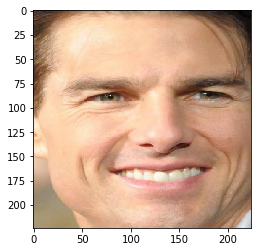

In [20]:
pyplot.imshow(Image.fromarray(X_test[0]))
pyplot.show()

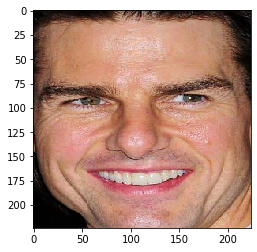

In [21]:
pyplot.imshow(Image.fromarray(X_test[1]))
pyplot.show()

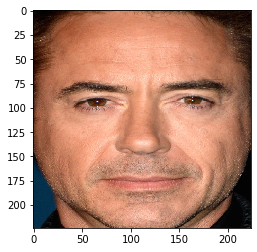

In [22]:
pyplot.imshow(Image.fromarray(X_test[2]))
pyplot.show()

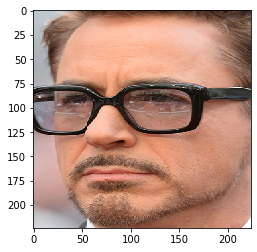

In [23]:
pyplot.imshow(Image.fromarray(X_test[3]))
pyplot.show()